In [12]:
# Import stuff
from pandas import DataFrame

from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.base import Bunch
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl.model import GLM
from nipype.interfaces.fsl.maths import TemporalFilter
from nipype.algorithms.confounds import CompCor
from nipype.interfaces.afni.model import Deconvolve, Remlfit

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# Set study variables
analysis_home = '/home/camachocm2/Analysis/ChEC/fmri_proc'
raw_dir = analysis_home + '/raw'
preproc_dir = analysis_home + '/preproc'
firstlevel_dir = analysis_home + '/subjectlevel'
secondlevel_dir = analysis_home + '/grouplevel'
workflow_dir = analysis_home + '/workflows'
timing_file = analysis_home + '/misc/affect_tense_neg.txt'

mni_template = analysis_home + '/template/MNI152_T1_3mm_brain.nii.gz'
mni_brainmask = analysis_home + '/template/MNI152_T1_3mm_brain_mask.nii.gz'
gordon_parc = analysis_home + '/template/composite_Gordon_atlas_3mm.nii.gz'

#subject_info = DataFrame.read_csv(analysis_home + '/../misc/subjs.csv')
#subjects_list = subject_info['SubjID'].tolist()
subjects_list = ['1000','1001','1002','1006','1007','1008','1011','1015','1016','1017']
#subjects_list = ['1000']

# data collection specs
TR = 0.8 #in seconds

In [13]:
# Select subjects list
infosource = Node(IdentityInterface(fields=['subjid']),
                  name='infosource')
infosource.iterables = [('subjid', subjects_list)]

# Pull files
file_template = {'preproc_func': preproc_dir + '/mnireg_func/{subjid}/proc_func.nii.gz', 
                 'motion': preproc_dir + '/mcflirt_displacement/{subjid}/func_unwarped_reoriented_st_mcf.nii.gz.par', 
                 'outliers': preproc_dir + '/art_outliers/{subjid}/art.preprocoutliers.txt'}

selectfiles = Node(SelectFiles(file_template), name='selectfiles')

# Sink data of interest (mostly for QC)
substitutions = [('_subjid_', '')] #output file name substitutions
datasink = Node(DataSink(base_directory = firstlevel_dir,
                        container = firstlevel_dir,
                        substitutions = substitutions), 
                name='datasink')

In [14]:
## Timing handling nodes
def affectiveTiming(timing_file, motion, outliers):
    from nipype import logging, config
    config.enable_debug_mode()
    logging.update_logging(config)
    from numpy import genfromtxt, zeros, column_stack, savetxt
    from os.path import abspath 
    
    motion = genfromtxt(motion, delimiter=None, dtype=None, skip_header=0)
    timing = genfromtxt(timing_file, delimiter=None, dtype=None, skip_header=0)
    censor_vol_list = genfromtxt(outliers, delimiter=None, dtype=None, skip_header=0)
    
    try:
        c = censor_vol_list.size
    except:
        c = 0
    
    d=len(motion)

    if c > 1:
        scrubbing = zeros((d,c),dtype=int)
        for t in range(c):
            scrubbing[censor_vol_list[t],t] = 1
        regres_matrix = column_stack((timing, motion, scrubbing))
    elif c == 1:
        scrubbing = zeros((d,c),dtype=int)
        scrubbing[censor_vol_list] = 1
        regres_matrix = column_stack((timing, motion, scrubbing))
    else:
        regres_matrix = column_stack((timing, motion))
    
    design_file_name = 'matrix.txt'
    savetxt(design_file_name, regres_matrix)
    design_file = abspath(design_file_name)
    #design_file = (design_file, 'emotion_motion')
    
    return(design_file)

def nuissance_matrix(motion, outliers):
    from nipype import logging, config
    config.enable_debug_mode()
    logging.update_logging(config)
    from numpy import genfromtxt, zeros, column_stack, savetxt
    from os.path import abspath 
    
    motion = genfromtxt(motion, delimiter=None, dtype=None, skip_header=0)
    censor_vol_list = genfromtxt(outliers, delimiter=None, dtype=None, skip_header=0)
    
    try:
        c = censor_vol_list.size
    except:
        c = 0
    
    d=len(motion)

    if c > 1:
        scrubbing = zeros((d,c),dtype=int)
        for t in range(c):
            scrubbing[censor_vol_list[t],t] = 1
        regres_matrix = column_stack((motion, scrubbing))
    elif c == 1:
        scrubbing = zeros((d,c),dtype=int)
        scrubbing[censor_vol_list] = 1
        regres_matrix = column_stack((motion, scrubbing))
    else:
        regres_matrix = column_stack((motion))
    
    design_file_name = 'matrix.txt'
    savetxt(design_file_name, regres_matrix)
    design_file = abspath(design_file_name)
    design_file = (design_file, 'nuissance')
    
    return(design_file)

# pull processing timeseries for each region in the atlas
def pull_atlas_timeseries(atlas, func):
    from nipype import logging, config
    config.enable_debug_mode()
    logging.update_logging(config)
    from pandas import DataFrame, Series
    from numpy import unique, zeros_like
    from nipype.interfaces.fsl.utils import ImageMeants 
    from nibabel import load, save, Nifti1Image
    from os.path import abspath
    from sklearn.preprocessing import StandardScaler
    
    timeseries_df = DataFrame()
    atlas_nifti = load(atlas)
    atlas_data = atlas_nifti.get_data()
    labels = unique(atlas_data)
    labels = labels[labels>0].astype(int)
    
    ts = ImageMeants()
    ts.inputs.in_file = func
    ts.inputs.out_file = 'timeseries.txt'
    
    for label in labels:
        temp = zeros_like(atlas_data)
        temp[atlas_data==label] = 1
        temp_nii = Nifti1Image(temp, atlas_nifti.affine, header=atlas_nifti.header)
        save(temp_nii, 'temp_mask.nii.gz')
        
        ts.inputs.mask = 'temp_mask.nii.gz'
        ts.run()
        region_timeseries = open('timeseries.txt').read().splitlines()
        timeseries_df['label' + str(int(label))] = Series(region_timeseries, index=None)
    
    std = StandardScaler()
    std.fit(timeseries_df)
    std_ts = std.fit_transform(timeseries_df)
    std_timeseries_df = DataFrame(data=std_ts,columns=timeseries_df.columns, index=None)
    
    std_timeseries_df.to_csv('atlas_timeseries.csv')
    timeseries_file = abspath('atlas_timeseries.csv')
    
    return(timeseries_file)

In [15]:
# make the nuissance matrix
nuissance_mat = Node(Function(input_names=['motion', 'outliers'],
                              output_names=['design_file'],
                              function=nuissance_matrix), 
                     name='nuissance_mat')

#nuissance regression
estmodel = Node(Deconvolve(polort=1, 
                           x1D='nuissance.xmat.1D', 
                           x1D_stop=True, 
                           mask=mni_brainmask), 
                name='estmodel')

get_resids = Node(Remlfit(errts_file='denoised_func.nii.gz', 
                          nobout=True, nofdr=True, 
                          mask=mni_brainmask), 
                  name='get_resids')

#high pass filter
high_pass = Node(TemporalFilter(highpass_sigma=128/TR), 
                 name='high_pass')

#pull timeseries for each region in the atlas and save
get_atlas_ts = Node(Function(input_names=['atlas', 'func'], 
                             output_names=['timeseries_file'], 
                             function=pull_atlas_timeseries), 
                    name='get_atlas_ts')
get_atlas_ts.inputs.atlas = gordon_parc

## Typical univariate analysis nodes

affective_timing = Node(Function(input_names=['timing_file', 'motion', 'outliers'],
                                 output_names=['design_file'],
                                 function=affectiveTiming), 
                        name='affective_timing')
affective_timing.inputs.timing_file = timing_file

get_betas = Node(Remlfit(errts_file='denoised_func.nii.gz', 
                         obeta='betas.nii.gz',
                         nobout=True, nofdr=True, 
                         mask=mni_brainmask), 
                 name='get_betas')

In [16]:

affective_timing = Node(Function(input_names=['timing_file', 'motion', 'outliers'],
                                 output_names=['design_file'],
                                 function=affectiveTiming), 
                        name='affective_timing')
affective_timing.inputs.timing_file = timing_file

#high pass filter
high_pass = Node(TemporalFilter(highpass_sigma=128/TR), 
                 name='high_pass')

#run the GLM
estmodel = Node(GLM(dat_norm = True,
                    out_file = 'betas.nii.gz', 
                    out_cope='cope.nii.gz',
                    out_t_name = 'tstat.nii.gz'), 
                name= 'estmodel')

In [17]:
L1workflow = Workflow(name='L1workflow_univariate')
L1workflow.connect([(infosource,selectfiles,[('subjid','subjid')]),
                    (selectfiles, affective_timing,[('motion','motion')]),
                    (selectfiles, affective_timing,[('outliers','outliers')]),
                    (affective_timing,estmodel,[('design_file','design')]),
                    (selectfiles,estmodel,[('preproc_func','in_file')]),
                    
                    (affective_timing, datasink, [('design_file','design_tnp')]),
                    (estmodel, datasink, [('out_cope','copes')]),
                    (estmodel, datasink, [('out_t','tstats')]),
                    (estmodel, datasink, [('out_file','betas')])
                   ])
L1workflow.base_dir = workflow_dir
L1workflow.write_graph(graph2use='flat')
L1workflow.run('MultiProc', plugin_args={'n_procs': 2, 'memory_gb':10})

181009-10:08:48,37 workflow INFO:
	 Generated workflow graph: /home/camachocm2/Analysis/ChEC/fmri_proc/workflows/L1workflow_univariate/graph.png (graph2use=flat, simple_form=True).
181009-10:08:48,62 workflow INFO:
	 Workflow L1workflow_univariate settings: ['check', 'execution', 'logging', 'monitoring']
181009-10:08:48,127 workflow INFO:
	 Running in parallel.
181009-10:08:48,134 workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 10.00/10.00, Free processors: 2/2.
181009-10:08:48,230 workflow INFO:
	 [Node] Setting-up "L1workflow_univariate.selectfiles" in "/home/camachocm2/Analysis/ChEC/fmri_proc/workflows/L1workflow_univariate/_subjid_1008/selectfiles".181009-10:08:48,230 workflow INFO:
	 [Node] Setting-up "L1workflow_univariate.selectfiles" in "/home/camachocm2/Analysis/ChEC/fmri_proc/workflows/L1workflow_univariate/_subjid_1015/selectfiles".

181009-10:08:48,240 workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
18100

In [ ]:
L1workflow = Workflow(name='L1workflow_network')
L1workflow.connect([(infosource,selectfiles,[('subjid','subjid')]),
                    (selectfiles, nuissance_mat,[('motion','motion')]),
                    (selectfiles, nuissance_mat,[('outliers','outliers')]),
                    (nuissance_mat, estmodel,[('design_file','ortvec')]),
                    (selectfiles, estmodel,[('preproc_func','in_files')]),
                    (estmodel, get_resids,[('x1D','matrix')]),
                    (selectfiles, get_resids,[('preproc_func','in_files')]),
                    (get_resids, high_pass,[('errts_file','in_file')]),
                    (high_pass, get_atlas_ts,[('out_file','func')]),
                    
                    (high_pass, datasink, [('out_file','processed_func')]),
                    (get_atlas_ts, datasink,[('timeseries_file','timeseries_file')])
                   ])
L1workflow.base_dir = workflow_dir
L1workflow.write_graph(graph2use='flat')
L1workflow.run('MultiProc', plugin_args={'n_procs': 2, 'memory_gb':10})

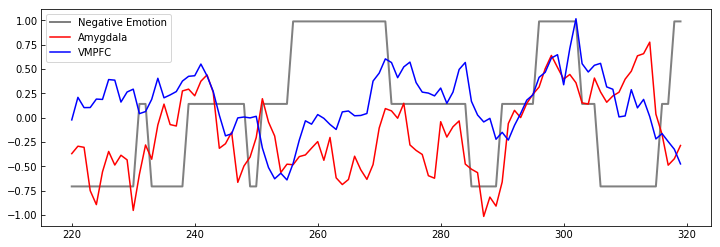

In [22]:
from sklearn.preprocessing import StandardScaler
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt

emotion = read_csv('/home/camachocm2/Analysis/ChEC/fmri_proc/misc/affect_tense_neg.csv',index_col=0)
std_emo = StandardScaler()
std_emo.fit(emotion)
std_emo_ts = std_emo.fit_transform(emotion)
std_emo_ts = std_emo_ts * 0.7 - .2
std_emotion = DataFrame(data=std_emo_ts,columns=emotion.columns, index=emotion.index)


from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
from glob import glob

files = glob('/home/camachocm2/Analysis/ChEC/fmri_proc/subjectlevel/timeseries_file/*/atlas_timeseries.csv')

dfs = []
for file in files:
    dfs.append(read_csv(file,index_col=0))

comb_df = concat(dfs)
avg_child = comb_df.groupby(comb_df.index).mean()

region_name = ['VMPFC','dacc','msfg','mfg','amyg']
region_label = ['label116','label27.0','label182.0','label273.0','label345.0']

i=0

ax = plt.figure(figsize=(12,4))
plt.tick_params(direction='in')
plt.plot(std_emotion.index[220:320],std_emotion['tense'][220:320],c='gray', label='Negative Emotion', linewidth=2)
plt.plot(std_emotion.index[220:320],avg_child['label345'][220:320],c='r', label='Amygdala')
plt.plot(std_emotion.index[220:320],avg_child[region_label[i]][220:320],c='b', label=region_name[i])
plt.legend()
plt.savefig('/home/camachocm2/Analysis/ChEC/pilot_results/avg_amyg_%s.svg' % region_name[i])
plt.show()
plt.close()


In [ ]:
sub_combined = concat([std_emotion,std_timeseries_df], axis=1)
import numpy as np
corr_mat = sub_combined.corr()
corr_mat[corr_mat==1] = np.nan
corr_mat2 = corr_mat[corr_mat>0.3]
corr_mat2[corr_mat<-0.3] = corr_mat
plt.figure()
plt.matshow(corr_mat2)
plt.legend()
plt.show()
plt.close()
#corr_mat.to_csv('1003_corr_mat.csv')

import seaborn as sns
#sns.set(context='talk')
fig, ax = plt.subplots(figsize=(20,18))
sns.heatmap(corr_mat2, fmt='d')